# Typical Application Circuit
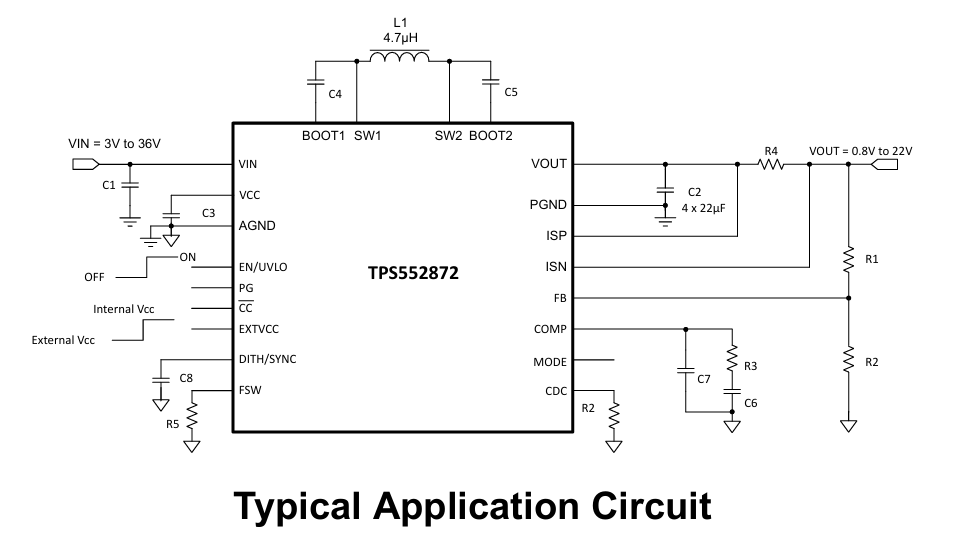
- input voltage range: 3V to 36V
- programmable output voltage range: 0.8V to 22V
- programmable switching frequency from 200kHz to 2.2MHz
- 4 Average inductor current limit, 4.7A max
    - Can limit the average and peak currents
- Can deliver 30W from a 12V input, and 25W from a 9V input
- Works in fixed-frequency PWM mode at moderate to heavy load currents
- In light load condition, can be configured to automatically transisiton to PFM mode or be in forced PWM mode
- Can dither the frequency to minimize EMI
- programmable input undervoltage lockout with hysteresis, when input voltage is above 3V, converter an be enabled by pulling the EN pin above 1.3V
- has output overvoltage protection
- Internal LDO supplies power to IC's output terminals (minus Vo), to ensure it is always powered by Vo or Vi, connect the EXTVCC pin to logic high or floating
- **Soft start** when input voltage is above the UVLO and EN is above the minimal voltage, converter starts to ramp up the output voltage by ramping an internal reference voltage from 0V to 1.2V within 3.6mS typically
- Thermal shutdown
- Switching frequency equation: $f_{sw}=\frac{1000}{0.05*R_{FSW}+35}$
- Can program the output voltage:
- 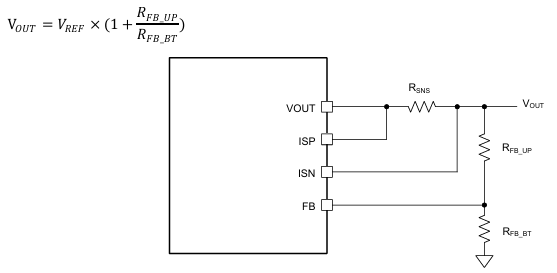
- Don't need voltage compensation, so leave CDC floating
- 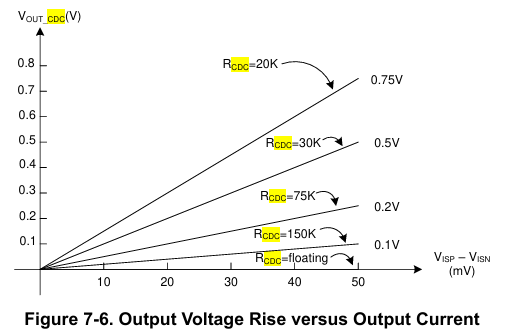
- 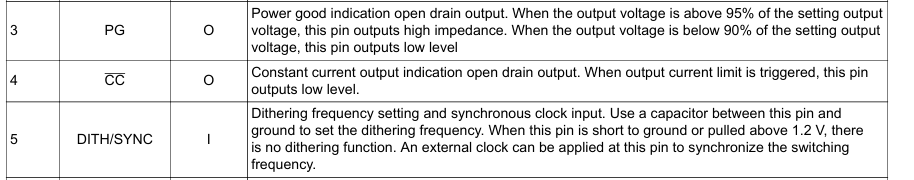
- Set the mode pin high so that the converter works in Forced PWM mode rather than auto PFM (Pulsed Frequency modulation) mode

# Functional Block Diagram
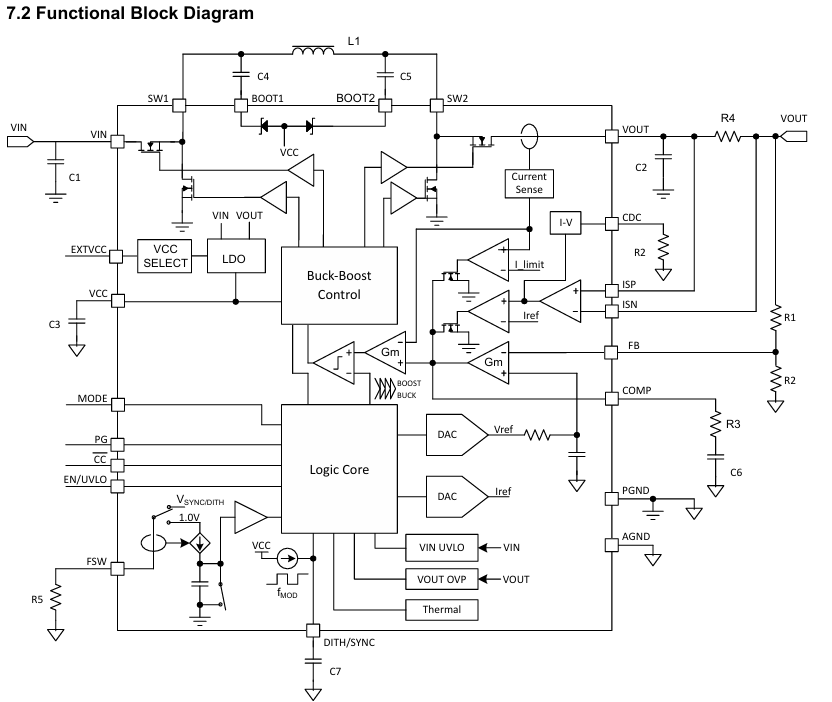
## Design
- converter designed to work with inductor values between 1uH and 10uH



### Inductor Selection
- For 2MHz switching frequency, a 1uH or 2.2uH inductor is  recommended
- For **buck mode**, the inductor selection is based on limiting the peak-to-peak current ripple to the maximum inductor current at the maximum input voltage.
- For a certain inductor, the inductor ripple current achieves maximum value when VOUT equals half of the maximum input voltage.
- Choosing higher inductance gets smaller inductor current ripple while smaller inductance gets larger inductor current ripple.

In [9]:
L = 2.2 *10**-6
VinMax = 17
Vo = 8.5
f = 2*10**6

IlR = (VinMax-Vo)*Vo/(L*f*VinMax)
print(f"Max peak to peak ripple current will be {IlR:.2f}A")


Max peak to peak ripple current will be 0.97A


-  For **boost mode**, the inductor selection is based on limiting the peak-to-peak current ripple to the maximum inductor current at the maximum output voltage.
-  For a certain inductor, the inductor ripple current achieves maximum value when VIN equals to the half of the maximum output voltage
-  Choosing higher inductance gets smaller inductor current ripple while smaller inductance gets larger inductor current ripple.

In [7]:
L = 2.2 *10**-6
Vin = 10
VoMax = 20
f = 2*10**6

IlR = Vin*(VoMax-Vin)/(L*f*VoMax)
print(f"Max peak to peak ripple current will be {IlR:.2f}A")

Max peak to peak ripple current will be 1.14A


- Peak Inductor Current is is the half the peak to peak ripple current plus the (max) average (i.e. DC) current
- 4.7A + 1.14/2 = 5.27A
- Expected value: 4 + 1.14/2 = 4.57A
- Recommended inductor values have max DCR of < 12mohms

### Input Capacitor
- In buck mode, the input capacitor supplies high ripple current
- Max RMS current occurs when the output voltage is half of in the input voltage, which gives
- $I_{CIN(RMS)}=\frac{I_{OUT}}{2}$
- Will need a capacitor that can handle 2.625V of ripple current
- recommend Ceramic cpacitors for their low ESR and high ripple current capability
- A total of 20uF *effective* capacitance is a good starting point
- Add a 0.1uF/0402 ceramic capacitor and place close to Vin
- Will use two of these 10uF caps: **GRM21BC8YA106ME11L**, hard to find 20uF caps

### Output Capacitor
- In boost mode, the output capacitor conducts high ripple current
- $I_{COUT(RMS)}=I_{OUT}\sqrt{\frac{V_{OUT}}{V_{IN}}-1}$
- For Vout = 20V, Vin = 3V, Iout = 5V, $I_{COUT(RMS)}= 12A$
- The ESR of the output capacitor causes an output voltage ripple
- $V_{RIPPLE(ESR)}= \frac{I_{OUT}*V_{OUT}}{V_{IN}}R_{COUT}$
- The capacitance also ausaes capacitive output voltage ripple in boost mode
- $V_{RIPPLE(CAP)}= \frac{I_{OUT}*(1-\frac{V_{IN}}{V_{OUT}})}{C_{OUT}*f_{SW}}$

In [8]:
# For a ripple of 50mV
Io = 4
Vi = 3
Vo = 20
f = 2*10**6
Vrip = 0.05

Co = Io*(1-Vi/Vo)/(Vrip*f)
print(f"For a max voltage ripple of 50mV, the output capacitor must be at least {Co*1000000:.2f}uF")

For a max voltage ripple of 50mV, the output capacitor must be at least 34.00uF


- Will use an output capacitor value of 100uF as that is the typical nominal value effective output capacitance range
- **EEEFTH101XAP** 100uF, ESR of 340mohm
- Add a 0.1-μF/0402 package ceramic capacitor and place it close to VOUT pin and GND pin to suppress high frequency noise
    - This cap will also allow the effective Rout value to go to zero

In [9]:
# For a output capacitance of 100uF
Io = 4
Vi = 3
Vo = 20
f = 2*10**6
Cout = 100 *10**-6

Vrip1 = Io*(1-Vi/Vo)/(Cout*f)
print(f"For a output capacitance of 100uF, the output voltage ripple is {Vrip1}V")
Rcout = 0.34
Vrip2 = Io*Vo*Rcout/Vi
print(f"For an ESR of 0.340ohms, the output voltage ripple is {Vrip2}V")

For a output capacitance of 100uF, the output voltage ripple is 0.017V
For an ESR of 0.340ohms, the output voltage ripple is 9.066666666666668V


# Loop Compensation
- uses average current control scheme
- inner current loop uses internal compensation and requires the inductor value to be larger than $1.2/f_{sw}$
- ***I am using a switching frequency of 2MHz and an inductor value of 2.2uH

In [11]:
fsw = 2*10**6 # Converter switching frequency
L = 2.2*10**-6 # Converter inductor value
print("The inductor value is: ", L)
print(f"1.2/fsw is {1.2/fsw}")
if  L > 1.2/fsw:
    print("Inductor value is larger than 1.2/fsw")
else:
    print("Inductor value is less than 1.2/fsw")

The inductor value is:  2.2e-06
1.2/fsw is 6e-07
Inductor value is larger than 1.2/fsw


- the COMP pin is the output of the internal voltage error amplifier
- An external compensationnetwork comprised of a resistor and cernamic capacitors is connected to the comp pin
- both buck and boost mode require loop compensation
- **the boost mode compensation is more restrictive due to the presence of a right half plane zero (RHPZ), and is therefore selected as the overall compensation from a loop stability point of view**
    - "Worst case scenario" calculations for boost mode are at **Minimum input voltage** and the **Maximum Output Voltage**
- $R_C = \frac{2\pi V_{OUT} R_{SENSE} C_{OUT} f_C}{(1-D) V_{REF} G_{EA}}$
- $C_C = \frac{R_{LOAD} C_{OUT}}{2 R_C}$
- $C_P = \frac{R_{COUT} C_{OUT}}{R_C}$
- where:
  - $R_{SENSE}$ is the equivalent internal current sense resistor, which is $55 m\ohm$
  - $C_{OUT}$ is the effective output capacitance
    - **Will use 100uF
  - $f_C$ is the selected crossover frequency
    - This is where the open loop gain is 1 or 0dB
    - The higher in frequency that the loop gain says above 0dB before corssing over, the faster the loop response
    - Generally accepted that loop gain corss over frequency should be no higher than the lower of either 1/10 of the switching frequency, or 1/5 of the RHPZ frequency

## Calculation Justification
### Issues
- https://chatgpt.com/c/6787f80f-2964-800b-9127-9d4506fc669f
- There is no single $f_{RHPZ}$ that will be valid for all conditions in my setup because the RHPZ frequency depends on parameters that vary with input voltage, output voltage and load resistance
- $f_{RHPZ} = \frac{R_{LOAD} (1-D)^2}{2\pi L}$
  - $R_{load} = \frac{V_{OUT}}{I_{OUT}}$
  - $D = \frac{V_{OUT}}{V_{OUT} + V_{IN}}$ (Buck-Boost approximation)
  - $D = \frac{V_{OUT} - V_{IN}}{V_{OUT}}$ (Boost approximation)
### Practical Solution
- Since the RHPZ varies across all operating conditions, the $f_C$ must be selected conservatively to ensure stability under all conditions
- Approach:
  1. Calculate $f_{RHPZ}$ for **Worst-Case Scenarios:**
     - Determine $f_{RHPZ}$ for lowest expected load resistance (maximum output current)
     - Also, calculate $f_{RHPZ}$ for the highest expected output voltage, as this typically results in a higher duty cycle and thus a lower $f_{RHPZ}$
  2. Set $f_C$ as a **Fraction of the Minimum** $f_{RHPZ}$:
     - use the lowest of $f_{RHPZ}$ to determine $f_C$
     - Common guideline is $f_c < f_{RHPZ}/5$

## **Testing for lowest expected load resistance (maximum output current)**
- According to the data sheet, the buck boost converter can deliver 30W from a 12V input and 25W from a 9V input

In [44]:
import math
# According to the data sheet, the buck boost converter can deliver 30W from a 12V input and 25W from a 9V input
# Will assume linear V_in-W relation
#Let
w1 =30; v1 = 12; w2 = 25; v2 = 9
m = (w1-w2)/(v1-v2)
b = w1 - v1*m
print("Assuming Linear V_in-W relation (IN BOOST MODE)")
print(f"The equation is W = {m:.2f}*V + {b}")

VinMax = 17
WMax = m*VinMax+10
print(f"The Maximim power the converter can output is WMAX({VinMax}) = {WMax:.2f} Watts")

VinMin = 3
WMin = m*VinMin+10
print(f"The Minimum pwer the converter can output is WMIN({VinMin}) = {WMin:.2f} Watts")

###### TODO - Insert tables and graphs showing Vout for Io = 5A, and Io for Vin = 3, 4, 17


print("CONCLUSION: OUTPUT CURRENT CAN ONLY BE EQUAL TO 5A IN BOOST MODE IF VIN = VOUT = 3V")
Io = 5; Vin = 3; Vo = 3
L = 2.2*10**-6 # Converter inductor value

RLoad = Vo/Io
D = 0 # Using Boost approximation
fRHPZ = (RLoad*(1-D)**2)/(2*math.pi*L)
fC = fRHPZ /5
print(f"RLoad = {Rload:0.2f} ohms and D = {D:0.2f}")
print(f"For lowest expected load resistance (maximum output current) the Right-Hand-Plane-Zero frequency is {fRHPZ/1000:.2f} kHz")
print(f"Therefore, the compensation frequency should be < {fC/1000:.2f} kHz")


Assuming Linear V_in-W relation (IN BOOST MODE)
The equation is W = 1.67*V + 10.0
The Maximim power the converter can output is WMAX(17) = 38.33 Watts
The Minimum pwer the converter can output is WMIN(3) = 15.00 Watts
CONCLUSION: OUTPUT CURRENT CAN ONLY BE EQUAL TO 5A IN BOOST MODE IF VIN = VOUT = 3V
Rload = 0.60 ohms and D = 0.00
For lowest expected load resistance (maximum output current) the Right-Hand-Plane-Zero frequency is 43.41 kHz
Therefore, the compensation frequency should be < 8.68 kHz


## **Testing For Highest Expected Output voltage & Highest Input Voltage (Highest Power)**
- Maximum Output voltage of the converter is 20V
- From the previous script, the maximum power output would be 38.33 Watts

In [46]:
Vo = 20; Vi = 17
Io = WMax/Vo

RLoad = Vo**2/WMax
D = (Vo-Vi)/Vo

fRHPZ = (RLoad*(1-D)**2)/(2*math.pi*L)
fC = fRHPZ /5
print(f"RLoad = {RLoad:0.2f} ohms and D = {D:0.2f}")
print(f"For Highest Expected Output Voltage & Highest Input Voltage the Right-Hand-Plane-Zero frequency is {fRHPZ/1000:.2f} kHz")
print(f"Therefore, the compensation frequency should be < {fC/1000:.2f} kHz")
print(Io)

RLoad = 10.43 ohms and D = 0.15
For Highest Expected Output Voltage & Highest Input Voltage the Right-Hand-Plane-Zero frequency is 545.40 kHz
Therefore, the compensation frequency should be < 109.08 kHz
1.9166666666666667


## **Testing For Highest Expected Output voltage & Lowest Input Voltage (Largest Duty cycle)**
- Maximum Output voltage of the converter is 20V
- Minimim Input Voltage is 3V, the maximum output power would be 15W

In [45]:
Vo = 20; Vi = 3; W = 15
Io = W/Vo

RLoad = Vo**2/W
D = (Vo-Vi)/Vo

fRHPZ = (RLoad*(1-D)**2)/(2*math.pi*L)
fC = fRHPZ /5
print(f"RLoad = {RLoad:0.2f} ohms and D = {D:0.2f}")
print(f"For Highest Expected Output Voltage & Lowest Input Voltage the Right-Hand-Plane-Zero frequency is {fRHPZ/1000:.2f} kHz")
print(f"Therefore, the compensation frequency should be < {fC/1000:.2f} kHz")
print(Io)

RLoad = 26.67 ohms and D = 0.85
For Highest Expected Output Voltage & Lowest Input Voltage the Right-Hand-Plane-Zero frequency is 43.41 kHz
Therefore, the compensation frequency should be < 8.68 kHz
0.75


#### **Will choose a compensation frequency of $f_c = 7$kHz**!!!!!!!!!!!!!!!!!!!!!!!!
- Using Highest Expected output voltage and lowest Expected Input Voltage Case

In [12]:
import math
#Using Highest Expected output voltage and lowest Expected Input Voltage Case
W = 15
Vo = 20
Rsense = 0.055 # 55 mOhms
Cout = 0.0001 # 100 uF
fc = 7000 # 7 kHz
D = 0.85 #Vin = 3V, Vout = 20V
Vref = 1.2
Gea = 0.00019 # 190uV/V

RLoad = Vo**2/W
Rcout = 0.340 # 340mOhm

R_c = (2*math.pi*Vo*Rsense*Cout*fc)/((1-D)*Vref*Gea)
print(f"Rc = {R_c/1000:.2f} kOhms")


C_c = RLoad*Cout/(2*R_c)
print(f"Cc = {C_c*1000000000:.2f} nF")

C_p = Rcout*Cout/(R_c)
print(f"Cp = {C_p*1000000000000:.2f} pF")

Rc = 141.46 kOhms
Cc = 9.43 nF
Cp = 240.34 pF
